In [8]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
np.random.seed(69)
torch.manual_seed(69)
random.seed(69)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=2).squeeze().to(torch.float32)
        return image, label
    
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    
batch_size = 32

with open("train/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == "0" or line[1] == "1":
        
        image_paths.append("train/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_train = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])

df_train = CustomDataset(image_paths, labels, transform=transform_train)
trainloader = DataLoader(df_train, batch_size=batch_size, shuffle=True)

with open("validation/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == "0"  or line[1] == "1":
        
        image_paths.append("validation/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_val = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])
df_val = CustomDataset(image_paths, labels, transform=transform_val)
valloader = DataLoader(df_val, batch_size=batch_size, shuffle=True)

with open("test/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("test/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transformation = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])

df_test = CustomDataset(image_paths, labels, transform=transformation)
testloader = DataLoader(df_test, batch_size=batch_size, shuffle=True)

In [9]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=150528, output_dim=2):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
    #self.sigmoid = torch.nn.Sigmoid() 
    #self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
          x = self.linear(x)
          #x = rdm pour le modèle aléatoire
          #x = self.sigmoid(x)
          #x = self.softmax(x)
          return x
  
device = torch.device("mps")

In [10]:
def iterate_data(dataloader, model, criterion, device, optimizer=None, is_training=False):

    loss_list = []
    total_samples = 0
    correct_predictions = 0

    if is_training:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(is_training):
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            output = model(images)
            loss = criterion(output, labels)
            loss_list.append(loss.item())  # Ajouter la perte actuelle à la liste

            total_samples += images.size(0)  # Accumuler le nombre total d'échantillons

            labels_ = torch.argmax(labels, dim=1)
            predicted = torch.argmax(output, dim=1)
            correct_predictions += (predicted == labels_).sum().item()  # Accumuler le nombre de prédictions correctes

            if is_training:
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                # update weights
                optimizer.step()

    mean_loss = torch.tensor(loss_list).mean().item()
    mean_accuracy = (100.0 * correct_predictions) / total_samples
    return mean_loss, mean_accuracy


In [14]:
device = torch.device("cuda")
model = LinearClassifier().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
train_loss, train_accuracy = iterate_data(model = model, 
                                               dataloader= trainloader, 
                                               is_training=False, 
                                               criterion=criterion,
                                               device = device)
val_loss, val_accuracy = iterate_data(model = model, 
                                               dataloader = valloader, 
                                               is_training= False,
                                               criterion=criterion,
                                               device = device)
print(f"Train Loss: {train_loss}, Train Accuracy : {train_accuracy} Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")


Train Loss: 0.8179665803909302, Train Accuracy : 33.630155947217865 Val Loss: 0.759728193283081, Val Accuracy: 43.729813228479145%


In [16]:
n_epoch = 25
device = torch.device("cuda")
model = LinearClassifier().to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.1) # w 0.001 0  lr 0.001 0.1

list_train_loss = []
list_train_accuracy = []
list_val_loss = []
list_val_accuracy = []

for epoch in range(n_epoch):
    
    #train
    train_loss, train_accuracy = iterate_data(model = model, 
                                               dataloader= trainloader, 
                                               is_training=True, 
                                               optimizer=optimizer,
                                               criterion=criterion,
                                               device = device)
    list_train_loss.append(train_loss)
    list_train_accuracy.append(train_accuracy)


    #validation

    val_loss, val_accuracy = iterate_data(model = model, 
                                            dataloader = valloader, 
                                           is_training= False,
                                           optimizer=optimizer,
                                           criterion=criterion,
                                           device = device)
    list_val_loss.append(val_loss)
    list_val_accuracy.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{n_epoch}], Train Loss: {train_loss}, Train Accuracy : {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")

Epoch [1/25], Train Loss: 0.3331192433834076, Train Accuracy : 85.94629510011995, Val Loss: 2.338249444961548, Val Accuracy: 43.19618031175397%


KeyboardInterrupt: 

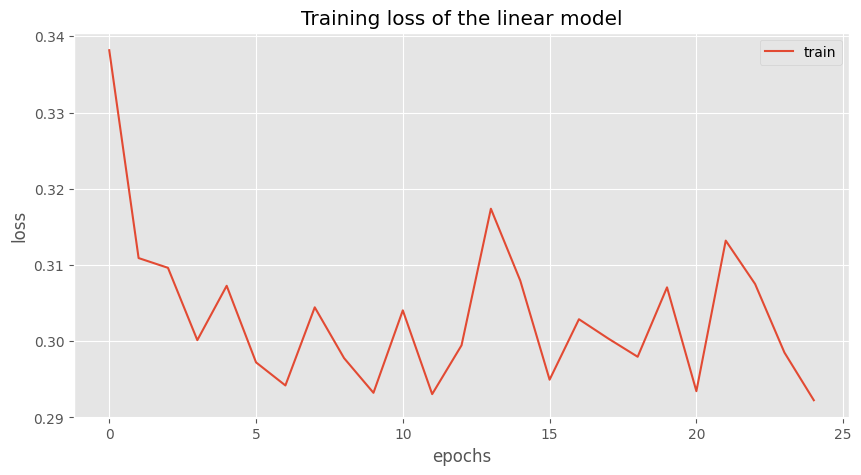

In [44]:
plt.style.use("ggplot")

plt.rcParams.update()
plt.figure(figsize=(10, 5))
plt.title("Training loss of the linear model")
plt.plot(list_train_loss, label="train")
# plt.plot(list_val_loss, label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()


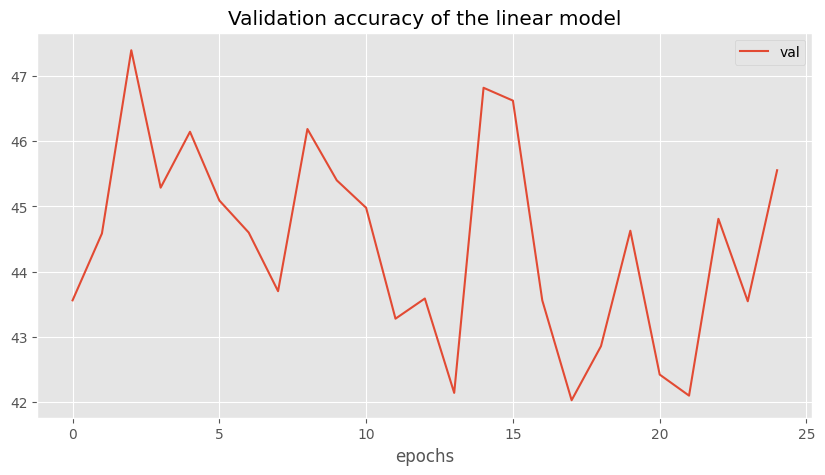

In [45]:
plt.style.use("ggplot")

plt.rcParams.update()
plt.figure(figsize=(10,5))
plt.title("Validation accuracy of the linear model")
plt.plot(list_val_accuracy,label="val")
#plt.plot(list_val_loss,label="validation")
plt.xlabel("epochs")
plt.ylabel
plt.legend()
plt.show()

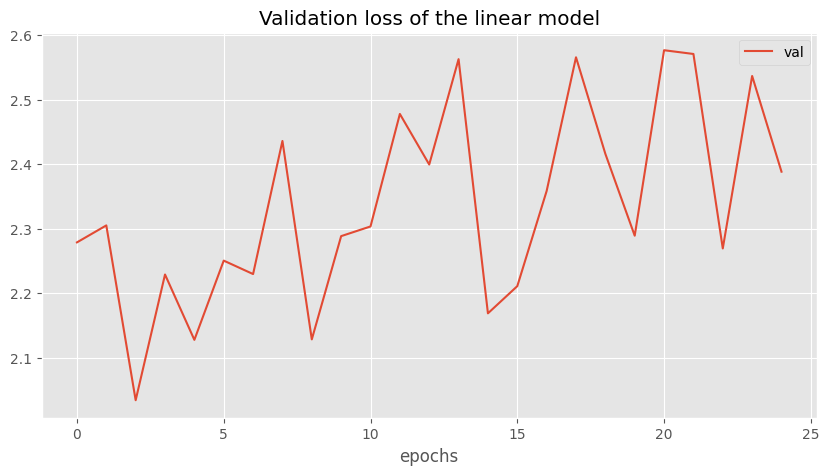

In [46]:
plt.style.use("ggplot")

plt.rcParams.update()
plt.figure(figsize=(10,5))
plt.title("Validation loss of the linear model")
plt.plot(list_val_loss,label="val")
#plt.plot(list_val_loss,label="validation")
plt.xlabel("epochs")
plt.ylabel
plt.legend()
plt.show()

# Modèle aléatoire

In [36]:
n_epoch = 25
device = torch.device("mps")
rd_accuracy = []
correct_predictions = 0
total_samples = 0


for epoch in range(n_epoch):
    rd_epoch_accuracy = 0
    total_samples = 0
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in valloader:
            labels = labels.to(device)
            labels_ = torch.argmax(labels, dim=1)
            predicted = torch.randint(low=0, high=2, size=(labels_.shape[0],))
            predicted = predicted.to(device)
            correct_predictions += (predicted == labels_).sum().item()
            total_samples += labels_.shape[0]
    rd_epoch_accuracy = (correct_predictions / total_samples) * 100
    rd_accuracy.append(rd_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{n_epoch}], Random Accuracy: {rd_epoch_accuracy}%")

Epoch [1/25], Random Accuracy: 48.98188456677433%
Epoch [2/25], Random Accuracy: 49.81041988484763%
Epoch [3/25], Random Accuracy: 49.96489257126808%
Epoch [4/25], Random Accuracy: 50.568740345457094%
Epoch [5/25], Random Accuracy: 49.0380564527454%
Epoch [6/25], Random Accuracy: 50.02106445723915%
Epoch [7/25], Random Accuracy: 51.06024434770398%
Epoch [8/25], Random Accuracy: 50.245752001123435%
Epoch [9/25], Random Accuracy: 50.273837944108976%
Epoch [10/25], Random Accuracy: 48.84145485184665%
Epoch [11/25], Random Accuracy: 50.06319337171745%
Epoch [12/25], Random Accuracy: 49.45934559752844%
Epoch [13/25], Random Accuracy: 49.64190422693442%
Epoch [14/25], Random Accuracy: 49.37508776857183%
Epoch [15/25], Random Accuracy: 50.79342788934138%
Epoch [16/25], Random Accuracy: 50.62491223142816%
Epoch [17/25], Random Accuracy: 49.571689369470576%
Epoch [18/25], Random Accuracy: 50.11936525768853%
Epoch [19/25], Random Accuracy: 49.7823339418621%
Epoch [20/25], Random Accuracy: 49.866

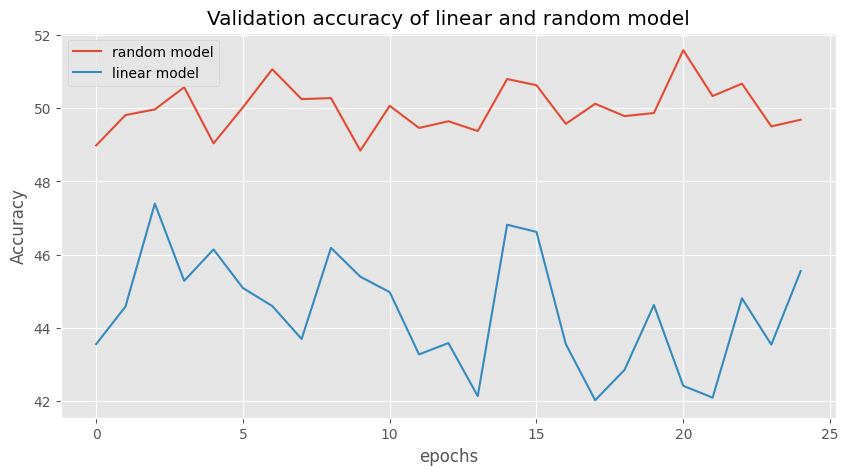

In [52]:
plt.style.use("ggplot")

plt.rcParams.update()

plt.figure(figsize=(10,5))
plt.title("Validation accuracy of linear and random model")
plt.plot(rd_accuracy,label="random model")
plt.plot(list_val_accuracy,label="linear model")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

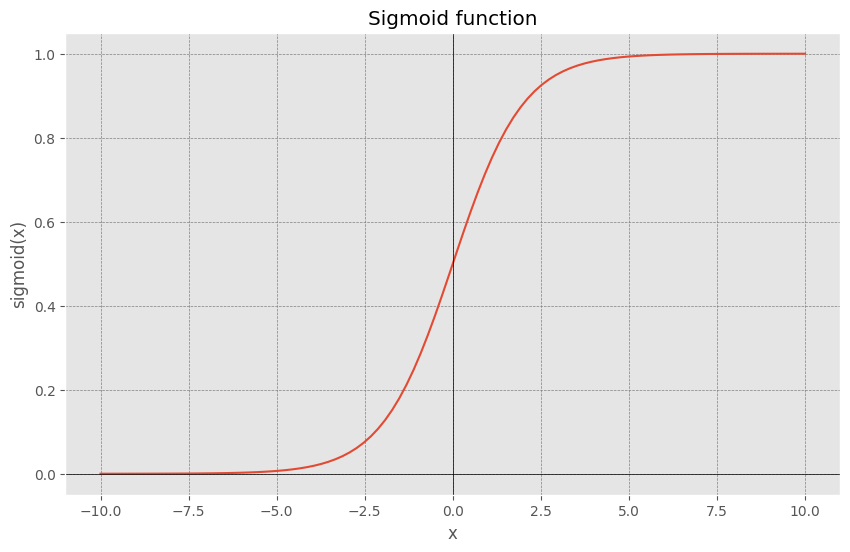

In [50]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Generate an array of values between -10 and 10 to compute the sigmoid
x_values = torch.linspace(-10, 10, 100)

# Compute the sigmoid of these values
y_values = sigmoid(x_values)
plt.style.use("ggplot")

plt.rcParams.update()

plt.figure(figsize=(10, 6))
plt.plot(x_values.numpy(), y_values.numpy())

# Draw the axes in the middle of the figure
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

# Set the title and labels
plt.title("Sigmoid function")
plt.xlabel("x")
plt.ylabel("sigmoid(x)")

plt.show()
